In [1]:
# Data processing
import utils as ut
import json
import os 

# Training and validation
from sklearn.model_selection import train_test_split

# Pre-processing
from PIL import Image

# model
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image


# Data Processing

In [2]:

annotations_file = open(os.path.join(ut.DATA_FOLDER, 'annotations.json'))
annotations_dict = json.load(annotations_file)
keys = list(annotations_dict.keys())
labels = [annotations_dict[key][43] for key in keys]

## Training and Validation
> **#1 decision:** not maintaning same id on same set. <br>
>   **motive:**  its possible to try to spoof someone not in the database


In [3]:
X_train, X_test, y_train, y_test = train_test_split(keys, labels, test_size=0.33, random_state=42)

In [4]:
# Evaluate percentage of classes in both train and test

sum(y_train)/len(y_train), sum(y_test)/len(y_test)

(0.6715077491532382, 0.6827794561933535)

## Pre Processing images

In [5]:
def resize_image(image_path, output_path, new_size):
    with Image.open(image_path) as image:
        resized_image = image#.resize(new_size)
        resized_image.save(output_path)


if False: # Run id test and train are empty
    new_size = (244, 244)
    for idx, key in enumerate(X_test):
        image_name = 'image_' + str(idx) + '.jpg'
        if labels[idx]: # If Spoof
            path = 'data\\test\\spoof'

        else:
            path = 'data\\test\\live'  
        
        original_path = os.path.join(ut.DATA_FOLDER, key)
        output_path = os.path.join(path, image_name) 
        resize_image(original_path, output_path, new_size)


    for idx, key in enumerate(X_train):
        image_name = 'image_' + str(idx) + '.jpg'
        if labels[idx]: # If Spoof
            path = 'data\\train\\spoof'

        else:
            path = 'data\\train\\live'  
        
        original_path = os.path.join(ut.DATA_FOLDER, key)
        output_path = os.path.join(path, image_name) 
        resize_image(original_path, output_path, new_size)





In [6]:
# I think we have enought images, if not we do image augmentation
train_datagen = image.ImageDataGenerator(
    rescale = 1./255
    # shear_range = 0.2
    # zoom_range = 0.2
    # horizontal_flip = True,
)
test_dataset = image.ImageDataGenerator(rescale=1/255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    'data\\train\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

test_generator = test_dataset.flow_from_directory(
    'data\\test\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

Found 19486 images belonging to 2 classes.
Found 9599 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

## Model 

In [9]:
# Using as a base model
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation='ReLU', input_shape=(224,224, 3))) # Need to check the mean size of the pictures for better performance

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64,(3,3), activation='ReLU'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='ReLU'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 flatten (Flatten)           (None, 774400)            0         
                                                                 
 dense (Dense)               (None, 64)                49561664  
                                                        

In [10]:
steps = train_generator.samples / train_generator.batch_size
steps = round(steps)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps,
    epochs = 5,
    validation_data = train_generator,
    validation_steps = 2
)

C:\Users\PLour\AppData\Local\Temp\ipykernel_400\2456806120.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
216/609 [=========>....................] - ETA: 22:57 - loss: 0.8731 - accuracy: 0.6759

234/609 [==========>...................] - ETA: 22:17 - loss: 0.8553 - accuracy: 0.6760

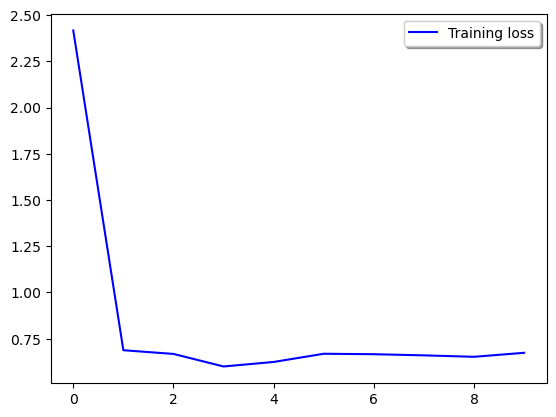

In [ ]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)